In [2]:
from model.vae.vae import VAE
from pipelines.vae_training import VAETrainingPipeline
import torchvision.transforms as transforms
from data.image_dataset import ImageDataset
from diffusers import get_cosine_schedule_with_warmup
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch

dataset = ImageDataset('../datasets/VAE_train', transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

# subset = Subset(dataset, range(300))
val_dataset = ImageDataset('../datasets/VAE_val', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True,
                        num_workers=8, prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

epochs = 50
vae = VAE().cuda()
vae.load_state_dict(torch.load('../runs/vae_base_nighttune/vae.safetensors'))
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-7)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=500, num_training_steps=len(dataloader) * epochs)


training_pipeline = VAETrainingPipeline(
    vae=vae,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    device='cuda'
)

In [2]:
from torchinfo import summary

summary(vae)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─VAEEncoder: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─VAEResidualBlock: 2-2             --
│    │    └─GroupNorm: 3-1               64
│    │    └─Conv2d: 3-2                  9,248
│    │    └─GroupNorm: 3-3               64
│    │    └─Conv2d: 3-4                  9,248
│    │    └─Identity: 3-5                --
│    └─VAEResidualBlock: 2-3             --
│    │    └─GroupNorm: 3-6               64
│    │    └─Conv2d: 3-7                  9,248
│    │    └─GroupNorm: 3-8               64
│    │    └─Conv2d: 3-9                  9,248
│    │    └─Identity: 3-10               --
│    └─Conv2d: 2-4                       9,248
│    └─VAEResidualBlock: 2-5             --
│    │    └─GroupNorm: 3-11              64
│    │    └─Conv2d: 3-12                 18,496
│    │    └─GroupNorm: 3-13              128
│    │    └─Conv2d: 3-14                 36,928
│ 

In [ ]:
training_pipeline.train(
    'vae_base_finetuned',
    '../runs',
    epochs=epochs,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    sample_period=1
)

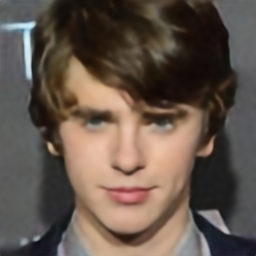

In [5]:
from data.utils import tensor_to_images
from diffusers.utils import make_image_grid

vae = VAE()
vae.load_state_dict(torch.load('../runs/vae_base_nighttune/vae.safetensors'))

i = 400
decoded = vae(dataset[i].unsqueeze(0), torch.normal(0, 1, size=(1, 4, 32, 32)))[0]
tensor_to_images(dataset[i].unsqueeze(0))[0]
make_image_grid(tensor_to_images(decoded), rows=1, cols=1)

In [ ]:
import matplotlib.pyplot as plt

img1 = dataset[2].cuda()
img2 = dataset[3].cuda()
seed = torch.normal(0, 1, (4, 32, 32)).cuda()

latent1 = vae.encoder(img1.unsqueeze(0), seed)[0]
latent2 = vae.encoder(img2.unsqueeze(0), seed)[0]

outs = []
for i in torch.arange(0.0, 1.0, 0.1):
    latent3 = i * latent2 + (1-i) * latent1
    out = vae.decoder(latent3)
    outs.append(out[0])

images = tensor_to_images(torch.stack([img1, img2]))

plt.imshow(make_image_grid(images, rows=1, cols=2))

new_images = tensor_to_images(torch.stack(outs))
make_image_grid(new_images, rows=1, cols=len(outs))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same